In [1]:
# hyperparameters
input_size = 784
output_size = 10
hidden_size = 500

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import shap

In [3]:
MODEL_ARG = input("Enter model name: ")

In [4]:
import torchvision
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1
BATCH_SIZE = 64
batch_size_train = 64
batch_size_test = 1000

mnist_train = torchvision.datasets.MNIST('/home/yoshisada/Desktop/condensa/notebooks/files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

mnist_test = torchvision.datasets.MNIST('/home/yoshisada/Desktop/condensa/notebooks/files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=VAL_SIZE,
)

# generate subset based on indices
train_split = Subset(mnist_train, train_indices)
val_split = Subset(mnist_train, val_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size_test, shuffle=True)

In [5]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

In [6]:

class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x, dim = 1)

In [7]:
test_losses = []
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
    #   data = data.reshape(-1, 28*28)
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [8]:
# TODO 3/7/2023
# note to self:
# will have to change 
# the load path 
# so it lines up 
# with the condensa_ouput files.

# load model in from memory
condensed_model = Network()
condensed_model.load_state_dict(torch.load('/home/yoshisada/Desktop/condensa/notebooks/' + MODEL_ARG + '.pth'))

<All keys matched successfully>

In [9]:
# load model in from memory
model = Network()
model.load_state_dict(torch.load('/home/yoshisada/Desktop/condensa/notebooks/model.pth'))


<All keys matched successfully>

In [10]:
# function to count zeros
def countNonZeroWeights(model):
    zeros = 0
    for param in model.parameters():
        if param is not None:
            zeros += torch.sum((param != 0).int()).item()
    return zeros

In [11]:
# function to get shap values 
def shapVals(model):
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images)

    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

    return (shap_numpy, test_numpy)

NON ZERO VALUES

In [12]:
og_model_non_zero = countNonZeroWeights(model)
print('Number of non-zeros on NON PRUNED model: ', og_model_non_zero)

Number of non-zeros on NON PRUNED model:  397510


In [13]:
con_model_non_zero = countNonZeroWeights(condensed_model)
print('Number of non-zeros on PRUNED model: ', con_model_non_zero)

Number of non-zeros on PRUNED model:  37195


STATISTICS: shap plots, accuracy, and non-zero values

In [14]:
# print out the accuracy values
print('ORIGINAL MODEL ACCURACY:')
test(model)
print('CONDENSED MODEL ACCURACY:')
test(condensed_model)

ORIGINAL MODEL ACCURACY:


size_average and reduce args will be deprecated, please use reduction='sum' instead.



Test set: Avg. loss: 0.1033, Accuracy: 9701/10000 (97%)

CONDENSED MODEL ACCURACY:

Test set: Avg. loss: 0.0917, Accuracy: 9762/10000 (98%)



In [15]:
# print out non zero values
print('ORIGINAL MODEL NON ZERO VALUES:', og_model_non_zero)
print('CONDENSED MODEL NON ZERO VALUES:', con_model_non_zero)
print('COMPRESSION ACHIEVED: {:.3f}%'.format((con_model_non_zero / og_model_non_zero * 100)))

ORIGINAL MODEL NON ZERO VALUES: 397510
CONDENSED MODEL NON ZERO VALUES: 37195
COMPRESSION ACHIEVED: 9.357%


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


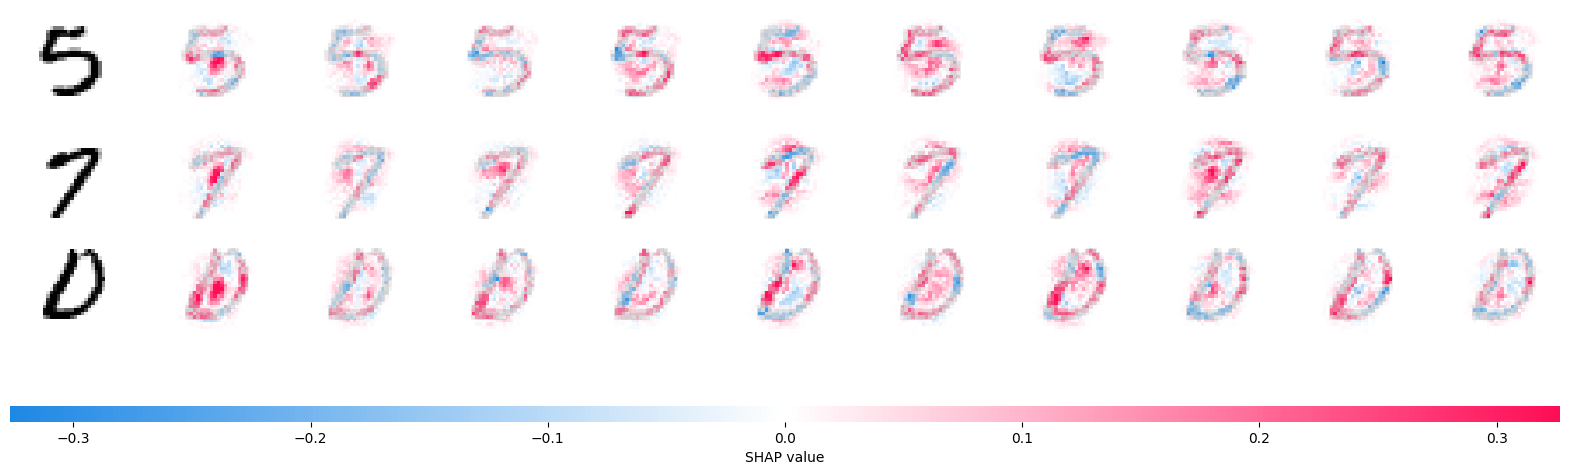

In [16]:
# print out ORIGINAL MODEL shap values
shap_numpy, test_numpy = shapVals(model)
shap.image_plot(shap_numpy, -test_numpy)

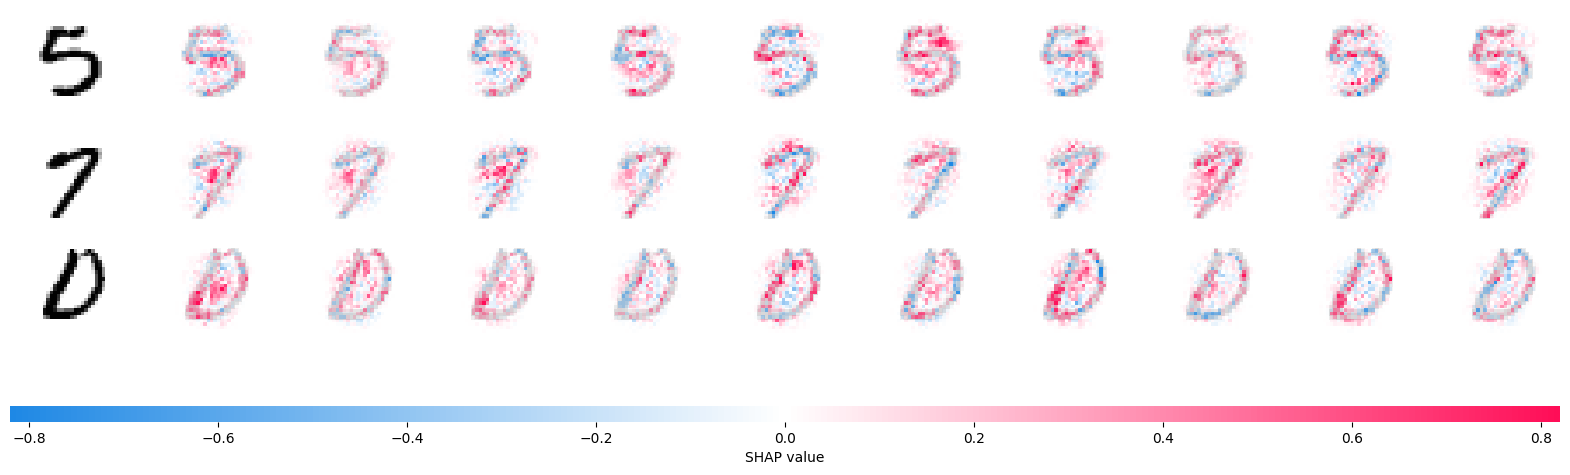

In [17]:
# print out CONDENSED MODEL shap values
shap_numpy, test_numpy = shapVals(condensed_model)
shap.image_plot(shap_numpy, -test_numpy)